In [ ]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

2024-05-29 17:29:43.383423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 17:29:43.383527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 17:29:43.500766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Setup the FinBERT model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
def lower_text_except_numbers(text):
    text = str(text)
    # Initialize an empty string to store the result
    result = ""

    # Iterate through each character in the input text
    for char in text:
        # Check if the character is a letter
        if char.isalpha():
            # If it's a letter, convert it to lowercase and append to the result
            result += char.lower()
        else:
            # If it's not a letter (e.g., a number or special character), just append it to the result
            result += char

    return result

In [ ]:
def create_news_sentiment_dataset(news_sentiments):
    # Convert all columns to string to avoid any non-string data issues
    news_sentiments['Titles'] = news_sentiments['Titles'].astype(str)
    news_sentiments['Paragraphs'] = news_sentiments['Paragraphs'].astype(str)

    # Extracting the content to be analyzed: Concatenate titles and paragraphs
    title_description = news_sentiments['Titles'] + " " + news_sentiments['Paragraphs']

    # Ensure no empty strings are processed which could raise errors
    title_description = [text if text.strip() != '' else "No content" for text in title_description]

    # Initialize lists to store results
    labels = []
    scores = []

    # Perform sentiment analysis with progress bar
    for result in tqdm(classifier(title_description), total=len(title_description), desc="Analyzing Sentiments"):
        labels.append(result['label'])
        scores.append(result['score'])

    # Add sentiment and scores to the DataFrame
    news_sentiments['sentiment'] = labels
    news_sentiments['sentiment_score'] = scores

    # Optionally, save the updated DataFrame to a CSV file
    news_sentiments.to_csv("output_news_sentiment.csv", index=False)

In [ ]:
# Load your dataset
news_sentiments = pd.read_csv("/kaggle/input/djia-news-2010-2024/DJIA_2010-2024_final.csv")

# Run the function to update dataset with sentiments
news_sentiments['Titles'] = news_sentiments["Titles"].apply(lambda row:lower_text_except_numbers(row))
news_sentiments['Paragraphs'] = news_sentiments["Paragraphs"].apply(lambda row:lower_text_except_numbers(row))
news_sentiments

,Titles,Paragraphs,Dates
0,stocks gain as traders look ahead to fed speak,stocks made small gains in holiday-thinned tra...,"May 6, 2024\n"
1,stock bulls back in charge as jobs fuel fed bets,stocks notched their biggest advance since feb...,"May 3, 2024\n"
2,tech jumps in late hours on apple’s solid outlook,the rally in tech heavyweights extended into l...,"May 2, 2024\n"
3,treasuries rally with fed not as hawkish as fe...,bonds rallied after jerome powell downplayed t...,"May 1, 2024\n"
4,wall street hit by fed jitters to close wild a...,the stock market sank in the final stretch of ...,"April 30, 2024\n"
...,...,...,...
6649,"stocks drop, dollar gains on korea clash, euro...","stocks sank, dragging the msci emerging market...","November 23, 2010\n"
6650,asian stocks drop on concern over spread of eu...,nan,"November 22, 2010\n"
6651,crude oil declines amid concern european debt ...,nan,"November 22, 2010\n"
6652,"u.s. stocks trim losses as technology, retail ...",nan,"November 22, 2010\n"


In [ ]:
create_news_sentiment_dataset(news_sentiments)

In [ ]:
news_sentiments

In [ ]:
import pandas as pd

# Sample loading step, replace with your actual data file path
df = pd.read_csv("/kaggle/working/output_news_sentiment.csv")

# Rename the 'Dates' column to 'date'
df.rename(columns={'Dates': 'date'}, inplace=True)

# Convert 'date' to datetime without specifying a format to allow automatic detection
df['date'] = pd.to_datetime(df['date'].str.strip())

# Format the dates with time and timezone, assuming the date conversion was successful
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

# Map the 'sentiment' column to a new 'label' column based on the sentiment
sentiment_to_label = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}
df['label'] = df['sentiment'].map(sentiment_to_label)

# Save the modified DataFrame back to a CSV
df.to_csv("/kaggle/working/output_news_sentiment.csv", index=False)

# Display the DataFrame to verify the changes
df


In [ ]:
import pandas as pd

# Load your data from a file
df = pd.read_csv('/kaggle/working/output_news_sentiment.csv')

# Define the date range
start_date = '2010-11-19'
end_date = '2023-09-01'

# Filter the data between the specified dates
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Save the filtered data to a new CSV file
df.to_csv('news_sentiment_data.csv', index=False)

In [ ]:
df

In [ ]:
# Extracting the date and polarized values from the previous dataframe
news_df = df.loc[:,["date","label"]]
news_df

In [ ]:
# Change the date format to match with the next csv file date format
news_df['date'] =pd.to_datetime(news_df['date'],infer_datetime_format=True)
news_df['date'] =pd.to_datetime(news_df['date'].dt.strftime("%m/%d/%y"))

# Aggregate the tweets polarization by avergae, sum and counts
Pol_df = pd.DataFrame(news_df.groupby('date')['label'].mean())
Pol_df.rename(columns={"label":"P_mean"},inplace=True)
Pol_df['P_sum'] = news_df.groupby('date')['label'].sum()
Pol_df['count'] = news_df.groupby('date')['label'].count()
Pol_df

In [ ]:
import pandas as pd

# Load your data from a file
df = pd.read_csv('/kaggle/input/djia-stock-2010-2023/dow_jones_data_2010_2023.csv')

# Define the date range
start_date = '2010-11-19'
end_date = '2023-09-01'

# Filter the data between the specified dates
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Save the filtered data to a new CSV file
filtered_df.to_csv('data_stock.csv', index=False)


In [ ]:
filtered_df

In [ ]:
news_df = pd.read_csv("/kaggle/working/data_stock.csv")
news_df.rename(columns={"Date":"date"},inplace=True)
news_df['date'] = pd.to_datetime(news_df['date'],infer_datetime_format=True)
news_df.set_index("date")

final_df = news_df.join(Pol_df,on='date',how="outer")
final_df

/tmp/ipykernel_33/1208737500.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  news_df['date'] = pd.to_datetime(news_df['date'],infer_datetime_format=True)


,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
0.0,2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,11203.549805,219400000.0,-1.0,-1.0,1.0
1.0,2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,11178.580078,152850000.0,-1.0,-3.0,3.0
2.0,2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,11036.370117,192820000.0,-1.0,-1.0,1.0
3.0,2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,11187.280273,138280000.0,NaN,NaN,NaN
NaN,2010-11-25,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3212.0,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213.0,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214.0,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,NaN,NaN,NaN
3215.0,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,NaN,NaN,NaN


In [ ]:
final_df = final_df[final_df['Open'].notna()]
final_df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
0.0,2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,11203.549805,219400000.0,-1.0,-1.0,1.0
1.0,2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,11178.580078,152850000.0,-1.0,-3.0,3.0
2.0,2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,11036.370117,192820000.0,-1.0,-1.0,1.0
3.0,2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,11187.280273,138280000.0,NaN,NaN,NaN
4.0,2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,11091.870117,68400000.0,-1.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
3212.0,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213.0,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214.0,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,NaN,NaN,NaN
3215.0,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,NaN,NaN,NaN


In [ ]:
final_df['P_mean'].fillna(0.000000, inplace=True)
final_df['P_sum'].fillna(0.0, inplace=True)
final_df['count'].fillna(0.0, inplace=True)

/tmp/ipykernel_33/377411734.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['P_mean'].fillna(0.000000, inplace=True)
/tmp/ipykernel_33/377411734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['P_mean'].fillna(0.000000, inplace=True)
/tmp/ipykernel_33/377411734.py:2: FutureWarning: A value is trying to be set on a cop

In [ ]:
final_df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
0.0,2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,11203.549805,219400000.0,-1.0,-1.0,1.0
1.0,2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,11178.580078,152850000.0,-1.0,-3.0,3.0
2.0,2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,11036.370117,192820000.0,-1.0,-1.0,1.0
3.0,2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,11187.280273,138280000.0,0.0,0.0,0.0
4.0,2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,11091.870117,68400000.0,-1.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
3212.0,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213.0,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214.0,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,0.0,0.0,0.0
3215.0,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,0.0,0.0,0.0


In [ ]:
final_df.to_csv("FinaData_2010.csv",index=False)

In [ ]:
final_df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
0.0,2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,11203.549805,219400000.0,-1.0,-1.0,1.0
1.0,2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,11178.580078,152850000.0,-1.0,-3.0,3.0
2.0,2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,11036.370117,192820000.0,-1.0,-1.0,1.0
3.0,2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,11187.280273,138280000.0,0.0,0.0,0.0
4.0,2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,11091.870117,68400000.0,-1.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
3212.0,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213.0,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214.0,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,0.0,0.0,0.0
3215.0,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,0.0,0.0,0.0


In [37]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
seed=43

In [2]:
df = pd.read_csv("/content/FinaData_2010.csv")
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
0,2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,11203.549805,219400000.0,-1.0,-1.0,1.0
1,2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,11178.580078,152850000.0,-1.0,-3.0,3.0
2,2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,11036.370117,192820000.0,-1.0,-1.0,1.0
3,2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,11187.280273,138280000.0,0.0,0.0,0.0
4,2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,11091.870117,68400000.0,-1.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
3212,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,0.0,0.0,0.0
3215,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,0.0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


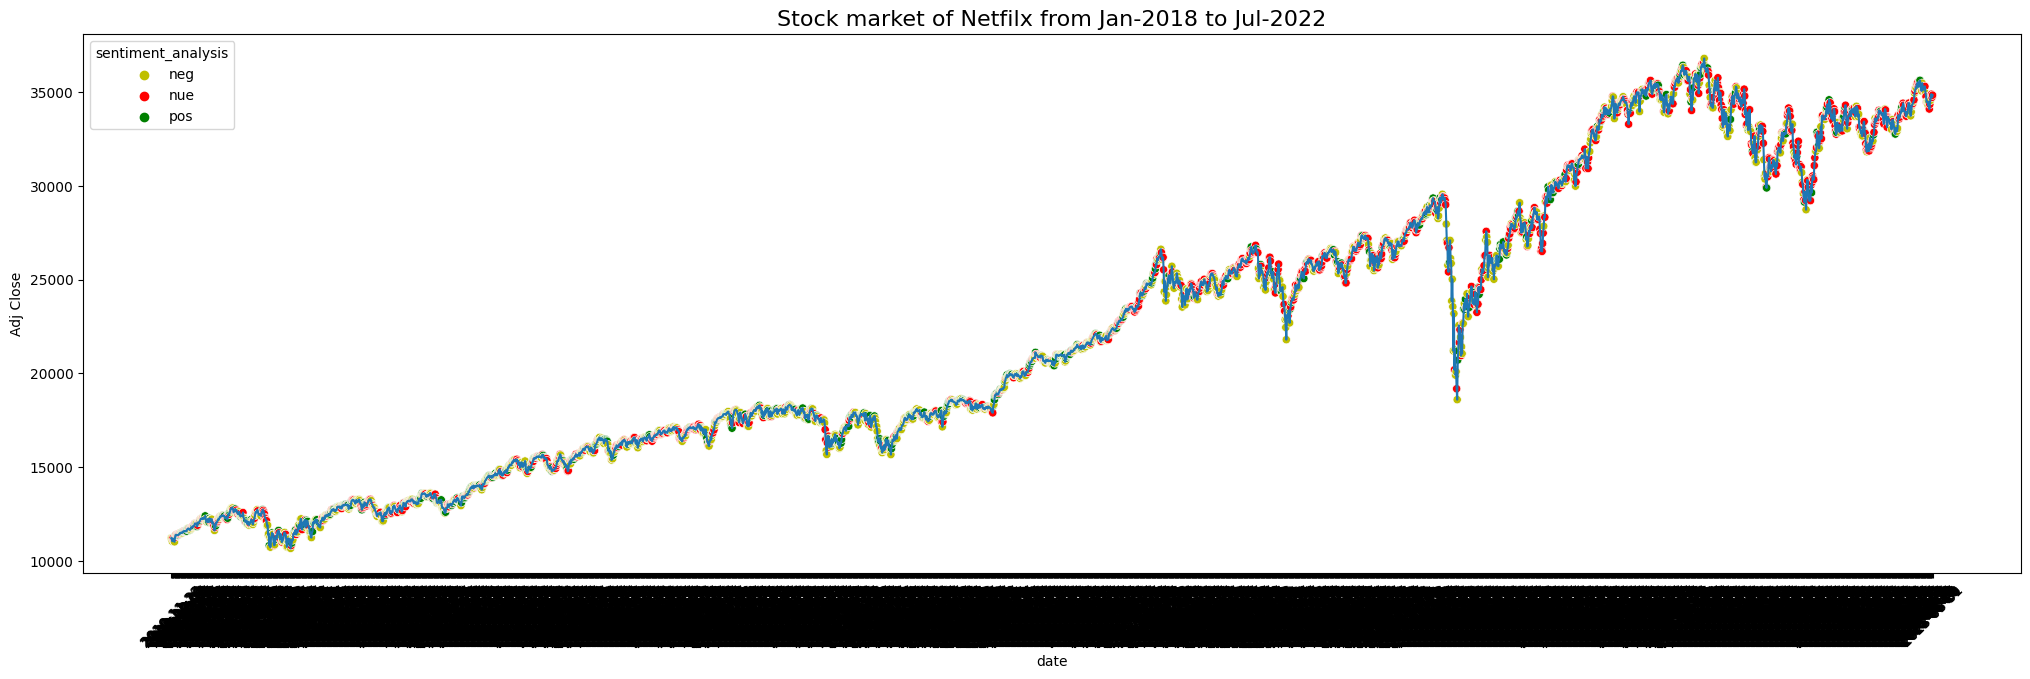

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netfilx from Jan-2018 to Jul-2022",fontsize=16);

In [ ]:
df['sentiment_analysis'].value_counts()

sentiment_analysis
neg    1369
nue    1260
pos     588
Name: count, dtype: int64

In [ ]:
df=df.drop(list(range(14)),axis=0,inplace=False)
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
14,2010-12-10,11370.059570,11413.690430,11357.719727,11410.320312,11410.320312,151820000.0,0.5,1.0,2.0
15,2010-12-13,11406.160156,11480.030273,11405.330078,11428.559570,11428.559570,151190000.0,0.0,0.0,2.0
16,2010-12-14,11429.240234,11514.080078,11428.940430,11476.540039,11476.540039,149860000.0,0.0,0.0,0.0
17,2010-12-15,11475.639648,11519.040039,11445.669922,11457.469727,11457.469727,189670000.0,0.0,0.0,2.0
18,2010-12-16,11457.929688,11514.839844,11421.299805,11499.250000,11499.250000,163040000.0,-1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3212,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,0.0,0.0,0.0
3215,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,0.0,0.0,0.0


In [3]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,219400000.0,11203.549805,-1.0
2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,152850000.0,11178.580078,-1.0
2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,192820000.0,11036.370117,-1.0
2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,138280000.0,11187.280273,0.0
2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,68400000.0,11091.870117,-1.0
...,...,...,...,...,...,...,...
2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,224640000.0,34559.980469,-1.0
2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,262550000.0,34852.671875,0.5
2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,236070000.0,34890.238281,0.0


In [4]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.02030324, 0.01521103, 0.02724776, ..., 0.23247537, 0.02097012,
        0.        ],
       [0.02110453, 0.01520644, 0.02478089, ..., 0.1591485 , 0.02001504,
        0.        ],
       [0.02018166, 0.01421655, 0.02240358, ..., 0.2031887 , 0.01457563,
        0.        ],
       ...,
       [0.9280891 , 0.9262903 , 0.93045533, ..., 0.2508429 , 0.92696662,
        0.5       ],
       [0.93043993, 0.92799778, 0.92694929, ..., 0.3674497 , 0.92052821,
        0.5       ],
       [0.92917986, 0.92451588, 0.92698473, ..., 0.30626501, 0.92495749,
        0.5       ]])

In [5]:
df_for_training.shape[1]

7

In [6]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 1:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (3212, 5, 6).
TrainY shape = (3212, 1, 1).


In [38]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_news, X_test_lstm_without_news, y_train_lstm_without_news, y_test_lstm_without_news = train_test_split(trainX[:,:,:-1], trainY, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_news, X_test_lstm_news, y_train_lstm_news, y_test_lstm_news = train_test_split(trainX, trainY, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

((2730, 5, 5), (2730, 5, 6))

In [39]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_news, X_val_lstm_without_news, y_train_lstm_without_news, y_val_lstm_without_news = train_test_split(X_train_lstm_without_news, y_train_lstm_without_news, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_news, X_val_lstm_news, y_train_lstm_news, y_val_lstm_news = train_test_split(X_train_lstm_news, y_train_lstm_news, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

((2320, 5, 5), (2320, 5, 6))

In [40]:
trainY.shape

(3212, 1, 1)

In [77]:
from keras.regularizers import l1,l2
import tensorflow as tf
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', kernel_regularizer=l2(0.01)))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.3))

    cnn_lstm_model.add(Dense(32, activation='relu'))
    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    cnn_lstm_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.00002), loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [78]:
# fit the model

cnn_lstm_model_without_news=build_model((X_train_lstm_without_news.shape[1],X_train_lstm_without_news.shape[2]))
cnn_lstm_model_news=build_model((X_train_lstm_news.shape[1],X_train_lstm_news.shape[2]))

history_without_news = cnn_lstm_model_without_news.fit(X_train_lstm_without_news, y_train_lstm_without_news, epochs=1100, batch_size=256, validation_data=(X_val_lstm_without_news, y_val_lstm_without_news), verbose=1, )


history_news = cnn_lstm_model_news.fit(X_train_lstm_news, y_train_lstm_news, epochs=1100, batch_size=256, validation_data=(X_val_lstm_news, y_val_lstm_news), verbose=1, )

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 4, 128)            1408      
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 2, 128)            0         
 ng1D)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 2, 128)            0         
                                                                 
 conv1d_29 (Conv1D)          (None, 1, 64)             16448     
                                                                 
 max_pooling1d_29 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 bidirectional_28 (Bidirect  (None, 1, 512)          

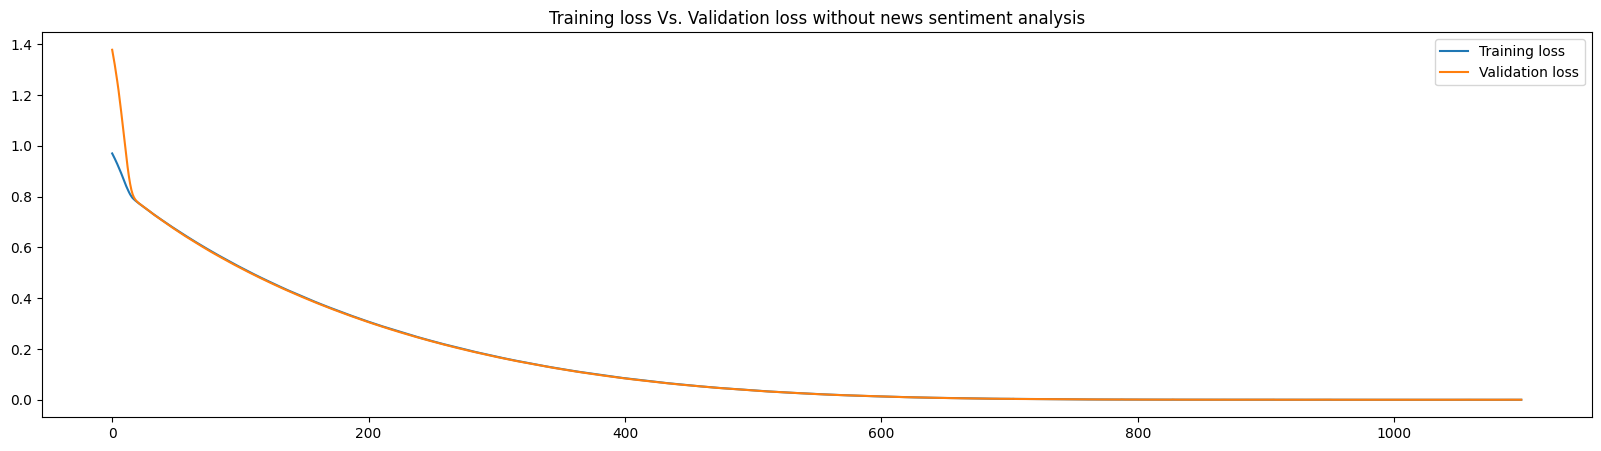

In [79]:
plt.figure(figsize=(20,5))
plt.plot(history_without_news.history['loss'], label='Training loss')
plt.plot(history_without_news.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without news sentiment analysis')
plt.legend()

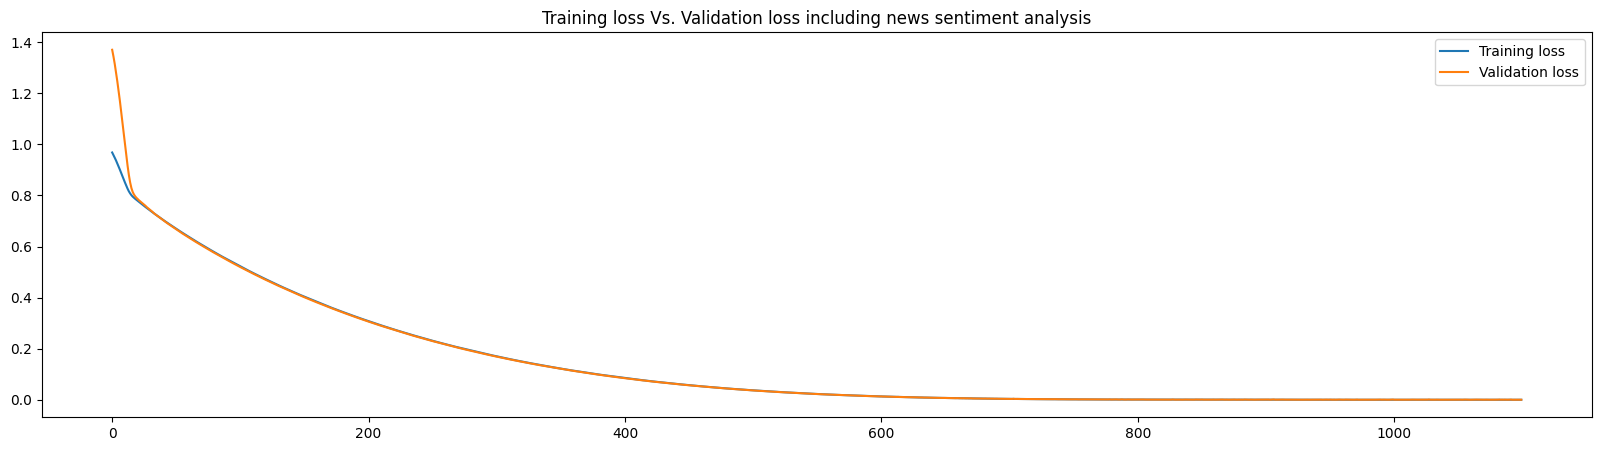

In [80]:
plt.figure(figsize=(20,5))
plt.plot(history_news.history['loss'], label='Training loss')
plt.plot(history_news.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including news sentiment analysis')
plt.legend()

In [72]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,news,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if news :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding news sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without news sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
        break
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [100]:
training_dates= df_for_training.index[:X_train_lstm_without_news.shape[0]]
#Make prediction
training_prediction_without_news = cnn_lstm_model_without_news.predict(X_train_lstm_without_news)

training_prediction_news = cnn_lstm_model_news.predict(X_train_lstm_news)

training_prediction_without_news=training_prediction_without_news.reshape(training_prediction_without_news.shape[0], training_prediction_without_news.shape[2])

training_prediction_news=training_prediction_news.reshape(training_prediction_news.shape[0], training_prediction_news.shape[2])

y_train_pred_lstm_without_news = scaler_for_inference.inverse_transform(training_prediction_without_news)

y_train_pred_lstm_news = scaler_for_inference.inverse_transform(training_prediction_news)

y_train_lstm_reshaped_without_news=y_train_lstm_without_news.reshape(y_train_lstm_without_news.shape[0], y_train_lstm_without_news.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_news)

73/73 [==============================] - 0s 4ms/step


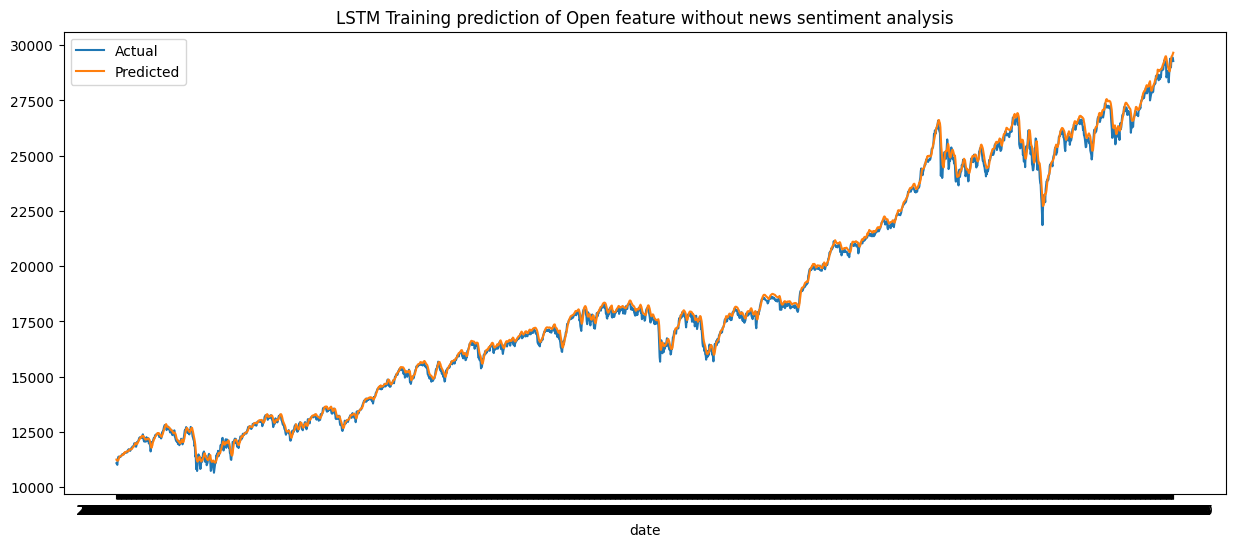

Mean square error for Open =47682.585701837634
Total mean square error 47682.585701837634


In [101]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_news)


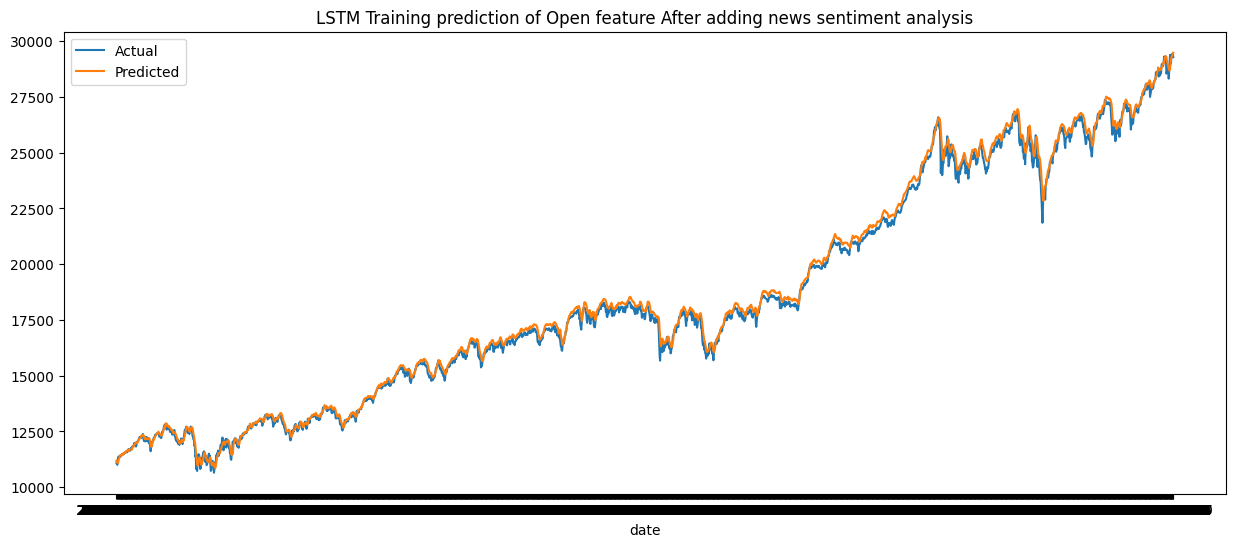

Mean square error for Open =67835.66987809971
Total mean square error 67835.66987809971


In [102]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_news)


In [81]:
validation_dates= df_for_training.index[X_train_lstm_without_news.shape[0]:X_train_lstm_without_news.shape[0] + X_val_lstm_without_news.shape[0]]
#Make prediction
validation_prediction_without_news = cnn_lstm_model_without_news.predict(X_val_lstm_without_news)

validation_prediction_news = cnn_lstm_model_news.predict(X_val_lstm_news)

validation_prediction_without_news=validation_prediction_without_news.reshape(validation_prediction_without_news.shape[0], validation_prediction_without_news.shape[2])


validation_prediction_news=validation_prediction_news.reshape(validation_prediction_news.shape[0], validation_prediction_news.shape[2])


y_val_pred_lstm_without_news = scaler_for_inference.inverse_transform(validation_prediction_without_news)
y_val_pred_lstm_news = scaler_for_inference.inverse_transform(validation_prediction_news)

y_val_actual_lstm_reshaped_without_news=y_val_lstm_without_news.reshape(y_val_lstm_without_news.shape[0], y_val_lstm_without_news.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_news)

13/13 [==============================] - 2s 7ms/step


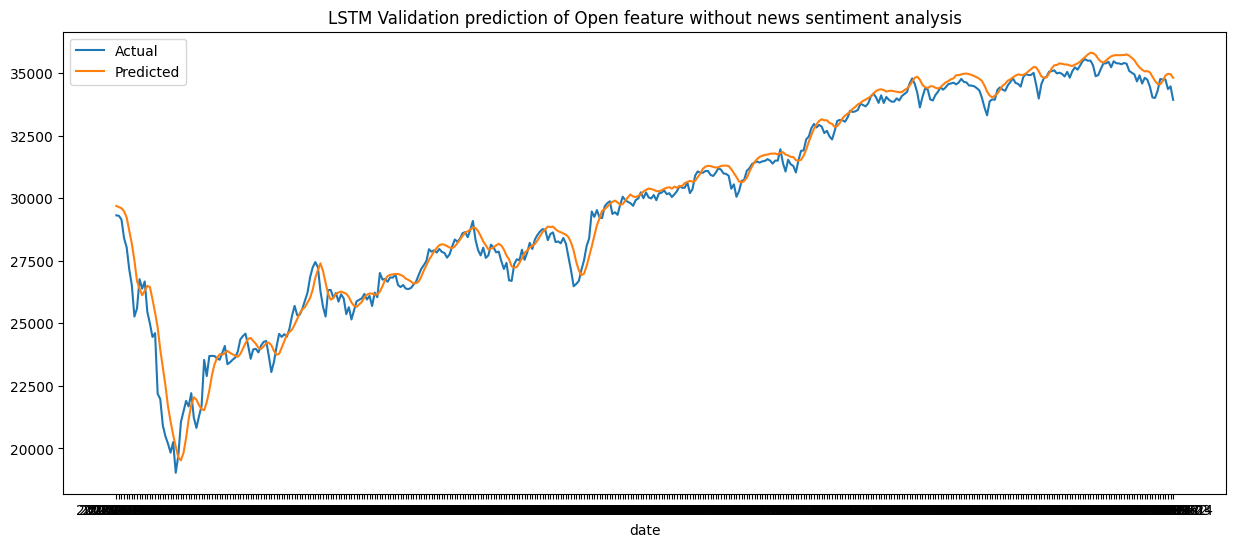

Mean square error for Open =306082.8488107728
Total mean square error 306082.8488107728


In [82]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_news)


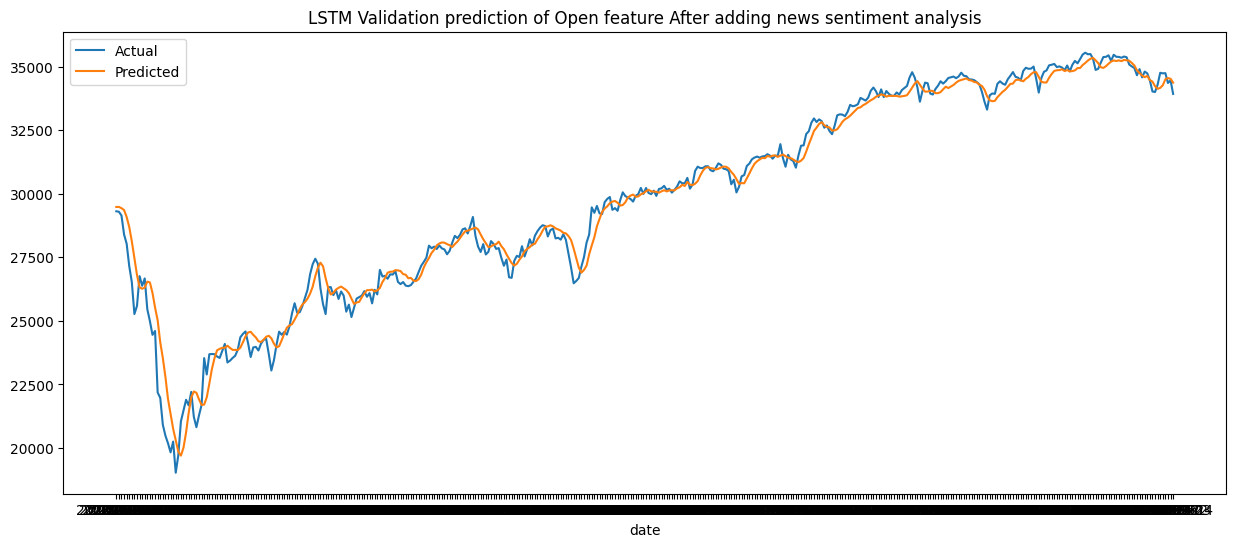

Mean square error for Open =290311.1201940863
Total mean square error 290311.1201940863


In [83]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_news)

In [96]:
testing_dates= df_for_training.index[-X_test_lstm_without_news.shape[0]:]
#Make prediction
testing_prediction_without_news = cnn_lstm_model_without_news.predict(X_test_lstm_without_news)
testing_prediction_news = loaded_model_news.predict(X_test_lstm_news)

testing_prediction_without_news=testing_prediction_without_news.reshape(testing_prediction_without_news.shape[0], testing_prediction_without_news.shape[2])
testing_prediction_news=testing_prediction_news.reshape(testing_prediction_news.shape[0], testing_prediction_news.shape[2])

y_test_pred_lstm_without_news = scaler_for_inference.inverse_transform(testing_prediction_without_news)
y_test_pred_lstm_news = scaler_for_inference.inverse_transform(testing_prediction_news)
print('before reshape',y_test_lstm_without_news.shape )
y_test_actual_lstm_reshaped_without_news=y_test_lstm_without_news.reshape(y_test_lstm_without_news.shape[0], y_test_lstm_without_news.shape[2])
print('after reshape', y_test_actual_lstm_reshaped_without_news.shape)

y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_news)
print('after inverse', y_test_actual_lstm.shape)

16/16 [==============================] - 2s 6ms/step
before reshape (482, 1, 1)
after reshape (482, 1)
after inverse (482, 1)


In [97]:
testing_dates

Index(['2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
       '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15',
       ...
       '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
       '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01'],
      dtype='object', name='date', length=482)

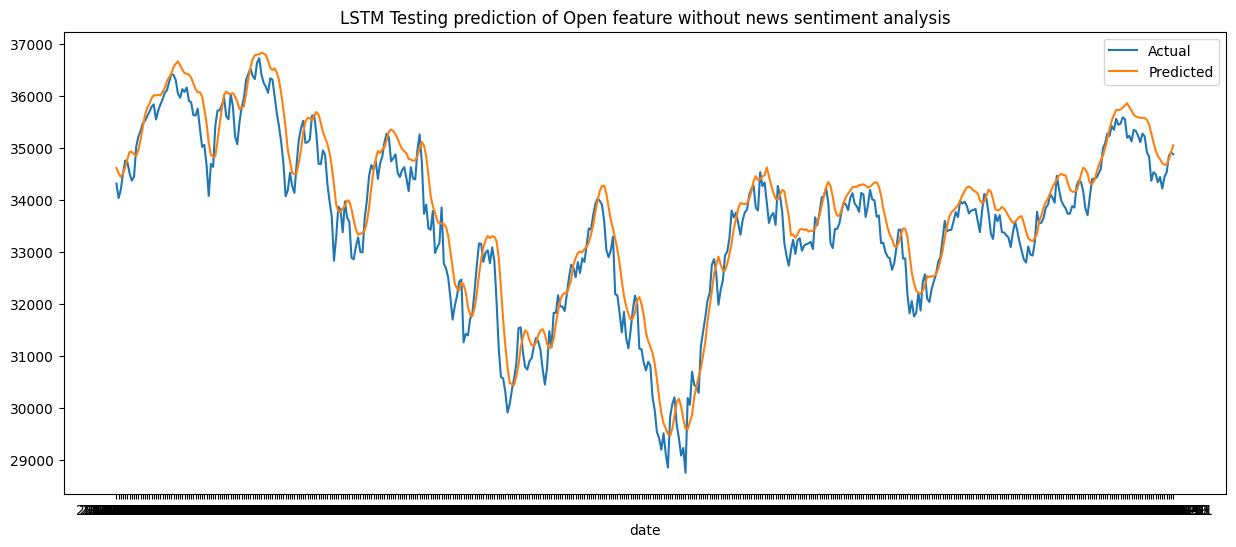

Mean square error for Open =248110.0623866671
Total mean square error 248110.0623866671


In [98]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_news)

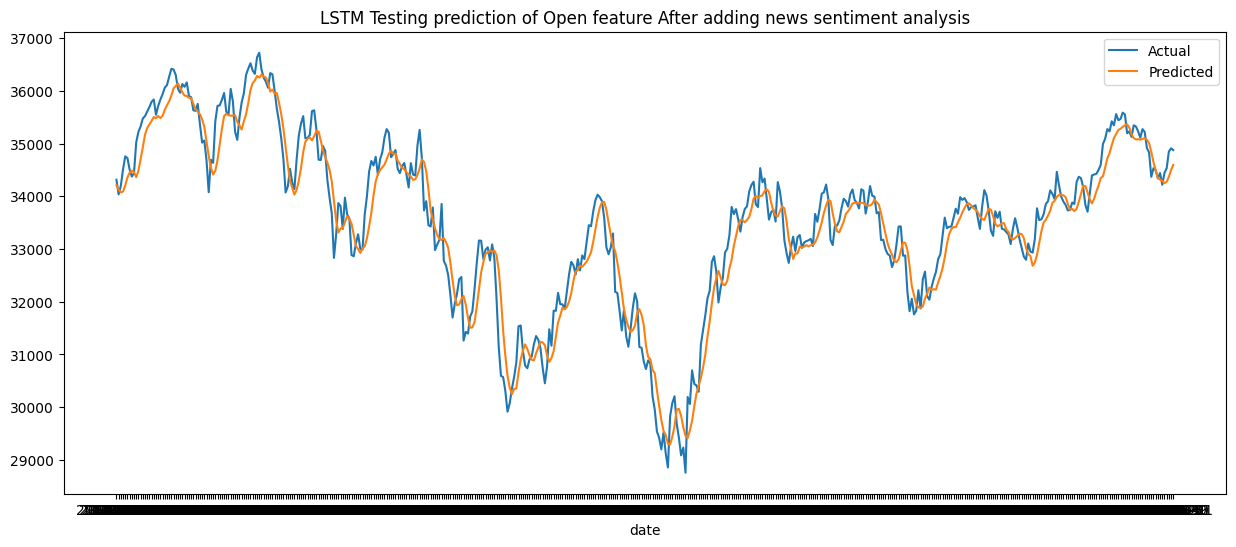

Mean square error for Open =178372.4075133691
Total mean square error 178372.4075133691


In [99]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_news)

In [94]:
cnn_lstm_model_without_news.save('/content/drive/MyDrive/cnn_lstm_2010_nonews.keras')


In [92]:
cnn_lstm_model_without_news.save('/content/drive/MyDrive/cnn_lstm_2010_nonews.h5')


In [93]:
cnn_lstm_model_news.save('/content/drive/MyDrive/cnn_lstm_2010_news.keras')

In [91]:
cnn_lstm_model_news.save('/content/drive/MyDrive/cnn_lstm_2010_news.h5')

In [95]:
loaded_model_news = tf.keras.models.load_model("/content/cnn_lstm_2010_news.h5")


In [90]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
